In [1]:
import glob
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from botorch.test_functions import Shekel

# EIPU

In [2]:
pickle_files = (
        glob.glob(os.path.join("results/20240715_6dec163", '*.pkl'))
)

# select files with eipu in the name
eipu_files = [file for file in pickle_files if 'eipu' in file]

In [3]:
with open(eipu_files[0], 'rb') as f:
    data = pickle.load(f)

data.keys()

dict_keys(['X', 'Y_noisy', 'Y_exact', 'X_acq', 'C', 'obj', 'problem', 'dim', 'switching_cost', 'xcs', 'xc_dims', 'algo', 'algo_kwargs', 'seed', 'budget'])

In [4]:
dfs = []

# Loop over each pickle file
for pickle_file in eipu_files:
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)

    # Extract 'X', 'Y_exact', 'X_acq', 'C', 'function', 'problem', 'dim', 'algo', 'seed', 'switching_cost', and 'xcs'
    X = data.get('X').tolist()
    Y_exact = data.get('Y_exact').squeeze(-1).tolist()
    X_acq = data.get('X_acq')
    C = data.get('C').tolist()

    # assert lengths of X, Y_exact, X_acq, and C are the same
    assert len(X) == len(Y_exact) == len(C), f"Lengths of X, Y_exact, X_acq, and C are not the same: {len(X)}, {len(Y_exact)}, {len(C)}"

    obj = data.get('obj')
    problem = data.get('problem')
    dim = data.get('dim')
    algo = data.get('algo_kwargs') if data.get('algo_kwargs') else data.get('algo')
    seed = data.get('seed')
    switching_cost = data.get('switching_cost')
    xcs = data.get('xcs')

    # Create a new dataframe for this row and add it to the list
    df = pd.DataFrame({
        'X': X,
        'Y_exact': Y_exact,
        'X_acq': X_acq['X_acq_final'],
        'C': C,
        'function': f"{obj._get_name()}{obj.m}" if isinstance(obj, Shekel) else f"{obj._get_name()}{obj.dim}",
        'problem': problem,
        'dim': dim,
        'algo': algo,
        'seed': seed,
        'switching_cost': switching_cost,
        'xcs': xcs
    })
    # get cummax of Y_exact
    df['best_Y'] = df['Y_exact'].cummax()
    df['regret'] = - obj._optimal_value - df['best_Y']  # _optimal_value is for minimum even when obj.negate is True
    
    # create setup change boolean
    df['setup_change'] = df['C'].ne(1)
    df['setup_number'] = df['setup_change'].cumsum()
    df['setup_improvement'] = df.groupby('setup_number')['best_Y'].transform(lambda x: x.max() - x)
    df['point_improvement'] = df['best_Y'].diff()
    df['point_improvement_deviation'] = df['point_improvement'] - df['X_acq']

    # assert regret is non-negative
    assert (df['regret'] >= 0).all(), f"Regret is negative: {df['regret']}"

    df['total cost'] = df['C'].cumsum()

    dfs.append(df.reset_index())

# Concatenate all the dataframes in the list
result = pd.concat(dfs, ignore_index=True)

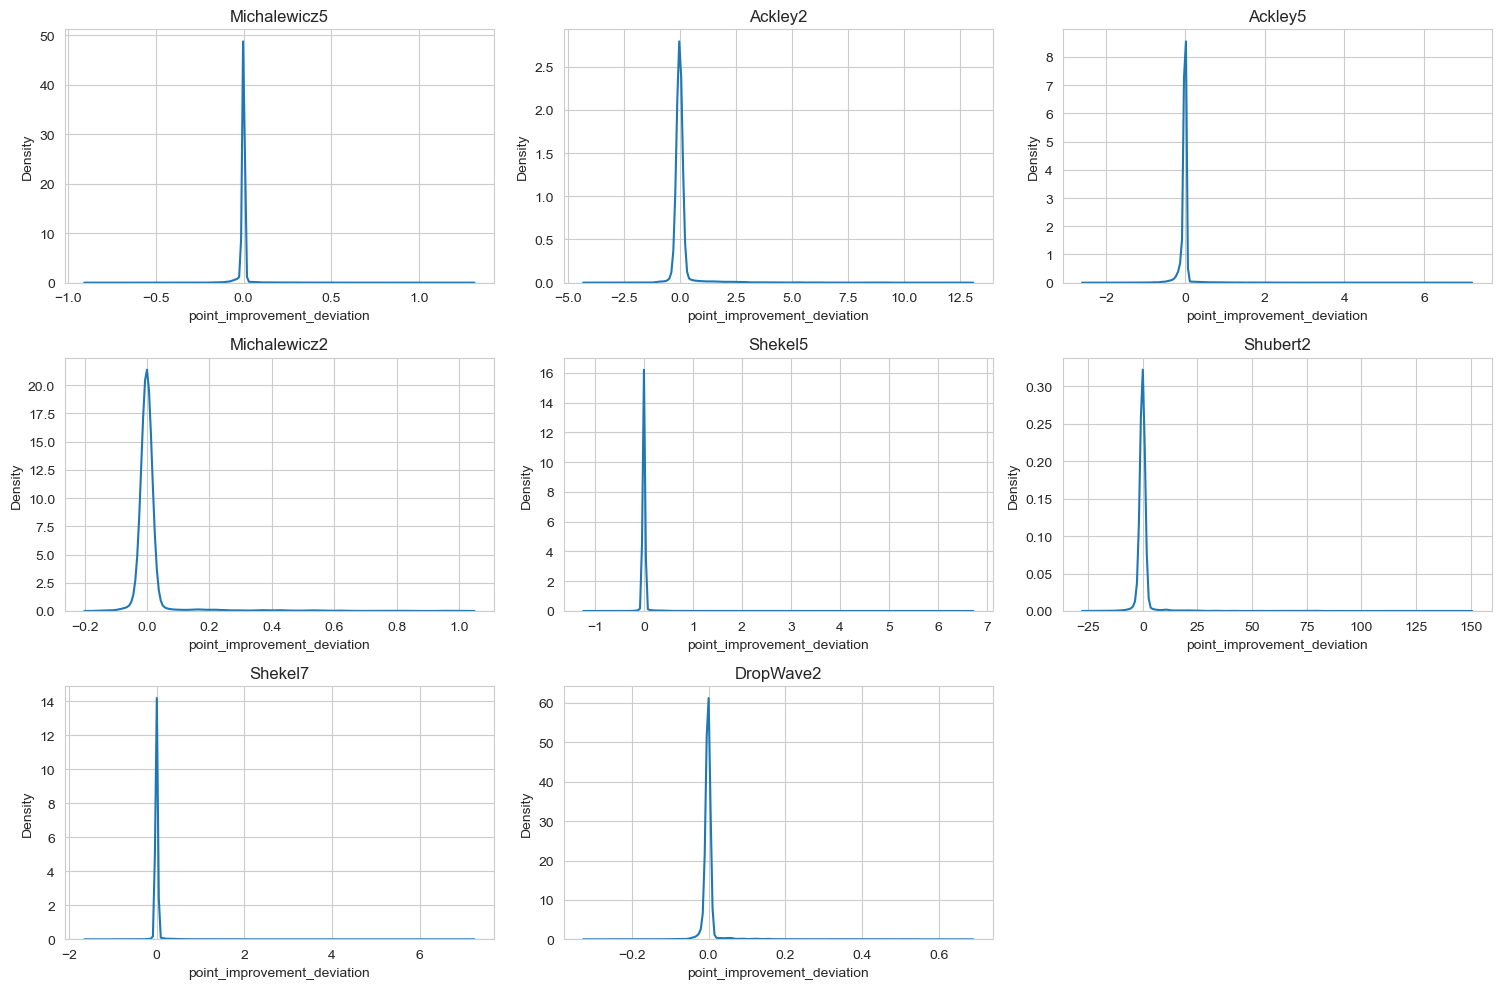

In [5]:
# Get unique functions
unique_functions = result['function'].unique()

# Calculate number of rows and columns for subplots
n = len(unique_functions)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

# Create figure with subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten axs to make it easier to iterate over
axs = axs.flatten()

# Loop over each unique function and each subplot
for func, ax in zip(unique_functions, axs):
    # Filter dataframe for current function
    df_func = result[result['function'] == func]

    # Create kdeplot of point improvement deviation
    sns.kdeplot(data=df_func, x='point_improvement_deviation', ax=ax)
    ax.set_title(func)

# Remove unused subplots
for ax in axs[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

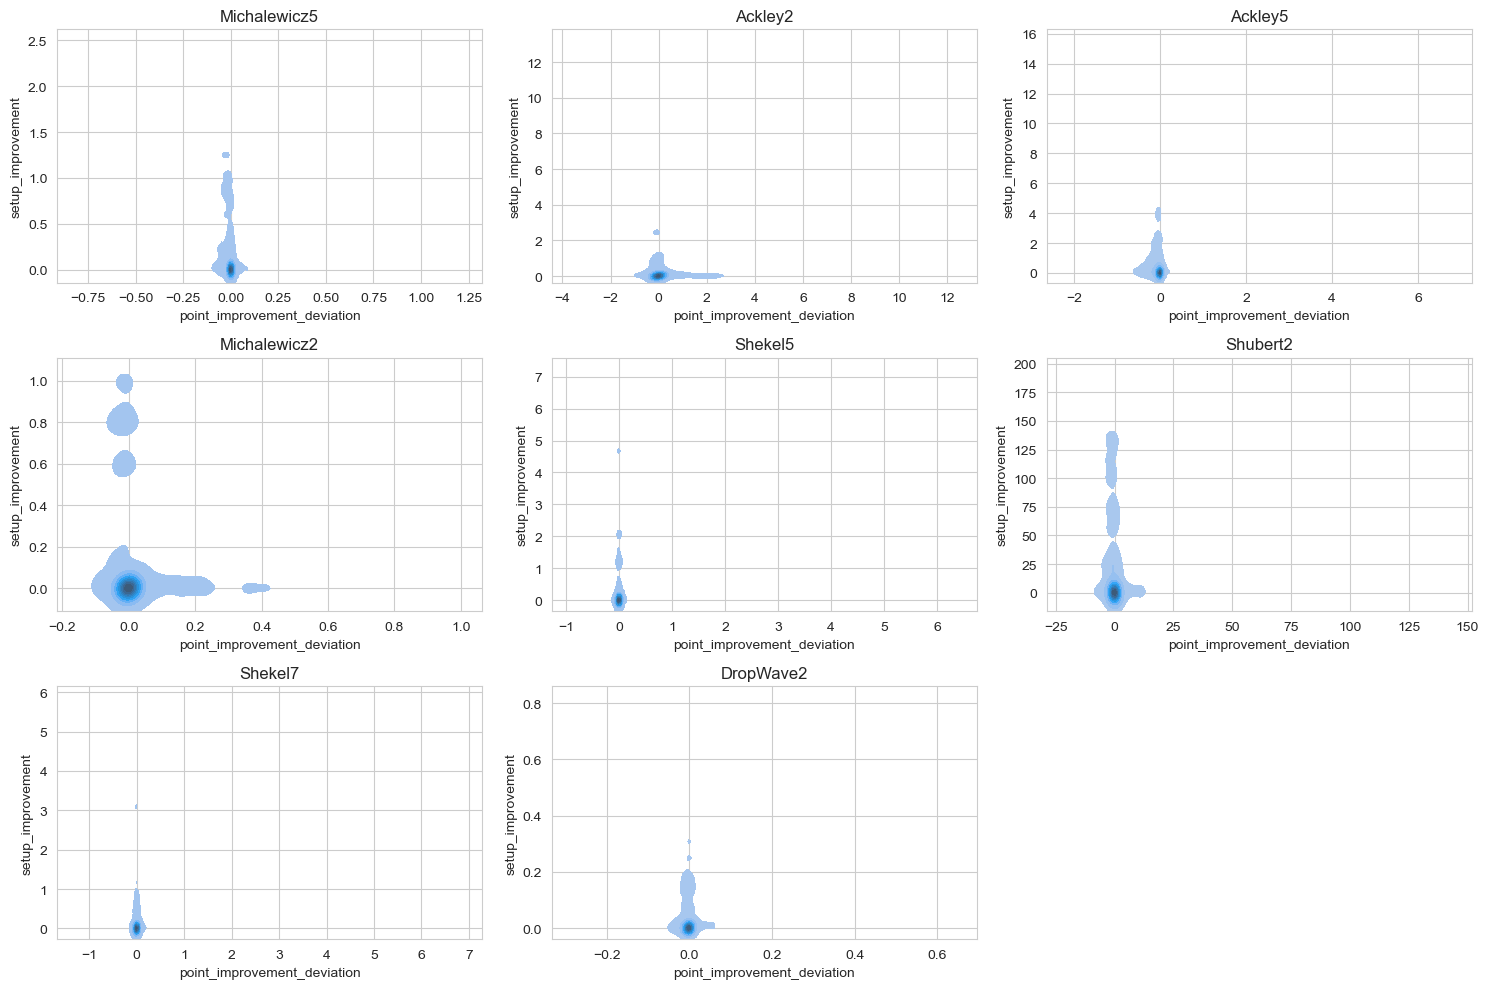

In [6]:
# Get unique functions
unique_functions = result['function'].unique()

# Calculate number of rows and columns for subplots
n = len(unique_functions)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

# Create figure with subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten axs to make it easier to iterate over
axs = axs.flatten()

# Loop over each unique function and each subplot
for func, ax in zip(unique_functions, axs):
    # Filter dataframe for current function
    df_func = result[result['function'] == func]

    # Plot KDE for point improvement deviation and setup improvement
    sns.kdeplot(data=df_func, x='point_improvement_deviation', y='setup_improvement', ax=ax, fill=True)
    ax.set_title(func)

# Remove unused subplots
for ax in axs[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

# MEAN

In [7]:
pickle_files = (
        glob.glob(os.path.join("results/20240715_6dec163", '*.pkl'))
)

# select files with eipu in the name
eipu_files = [file for file in pickle_files if ('bobatch' in file) or ('lookahead' in file) or ('mean' in file)]

In [8]:
with open(eipu_files[0], 'rb') as f:
    data = pickle.load(f)

data.keys()

dict_keys(['X', 'Y_noisy', 'Y_exact', 'X_acq', 'C', 'obj', 'problem', 'dim', 'switching_cost', 'xcs', 'xc_dims', 'algo', 'algo_kwargs', 'seed', 'budget'])

In [9]:
dfs = []

# Loop over each pickle file
for pickle_file in eipu_files:
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)

    # Extract 'X', 'Y_exact', 'X_acq', 'C', 'function', 'problem', 'dim', 'algo', 'seed', 'switching_cost', and 'xcs'
    X = data.get('X').tolist()
    Y_exact = data.get('Y_exact').squeeze(-1).tolist()
    X_acq = data.get('X_acq')
    C = data.get('C').tolist()

    # assert lengths of X, Y_exact, X_acq, and C are the same
    assert len(X) == len(Y_exact) == len(C), f"Lengths of X, Y_exact, X_acq, and C are not the same: {len(X)}, {len(Y_exact)}, {len(C)}"

    obj = data.get('obj')
    problem = data.get('problem')
    dim = data.get('dim')
    algo = data.get('algo_kwargs') if data.get('algo_kwargs') else data.get('algo')
    seed = data.get('seed')
    switching_cost = data.get('switching_cost')
    xcs = data.get('xcs')

    # Create a new dataframe for this row and add it to the list
    df = pd.DataFrame({
        'X': X,
        'Y_exact': Y_exact,
        'X_acq': X_acq['X_acq_final'],
        'X_acq_cheap': [t.item() if isinstance(t, torch.Tensor) else t for t in X_acq['X_acq_cheap']],
        'X_acq_expensive': [t.item() if isinstance(t, torch.Tensor) else t for t in X_acq['X_acq_expensive']],
        'x_acq_cheap': [t.item() if isinstance(t, torch.Tensor) else t for t in X_acq['x_acq_cheap']],
        'x_acq_expensive': [t.item() if isinstance(t, torch.Tensor) else t for t in X_acq['x_acq_expensive']],

        'C': C,
        'function': f"{obj._get_name()}{obj.m}" if isinstance(obj, Shekel) else f"{obj._get_name()}{obj.dim}",
        'problem': problem,
        'dim': dim,
        'algo': algo,
        'seed': seed,
        'switching_cost': switching_cost,
        'xcs': xcs
    })
    
    # get cummax of Y_exact
    df['best_Y'] = df['Y_exact'].cummax()
    df['regret'] = - obj._optimal_value - df['best_Y']  # _optimal_value is for minimum even when obj.negate is True
    
    # create setup change boolean
    df['setup_change'] = df['C'].ne(1)
    df['setup_number'] = df['setup_change'].cumsum()
    df['setup_improvement'] = df.groupby('setup_number')['best_Y'].transform(lambda x: x.max() - x)
    df['setup_augment_final'] = df.apply(
        lambda row: (row['X_acq_expensive'] - row['x_acq_expensive'])/row['switching_cost'] if row['setup_change'] else row['X_acq_cheap'] - row['x_acq_cheap'],
        axis=1
    )
    df['x_acq_final'] = df['X_acq'] - df['setup_augment_final']
    df['setup_deviation'] = df['setup_improvement'] - df['setup_augment_final']
    df['point_improvement'] = df['best_Y'].diff()
    df['point_improvement_deviation'] = df['point_improvement'] - df['X_acq']
    
    df['acq_ratio'] = df['setup_augment_final'] / df['X_acq']

    # assert regret is non-negative
    assert (df['regret'] >= 0).all(), f"Regret is negative: {df['regret']}"

    df['total cost'] = df['C'].cumsum()

    dfs.append(df.reset_index())

# Concatenate all the dataframes in the list
result = pd.concat(dfs, ignore_index=True)

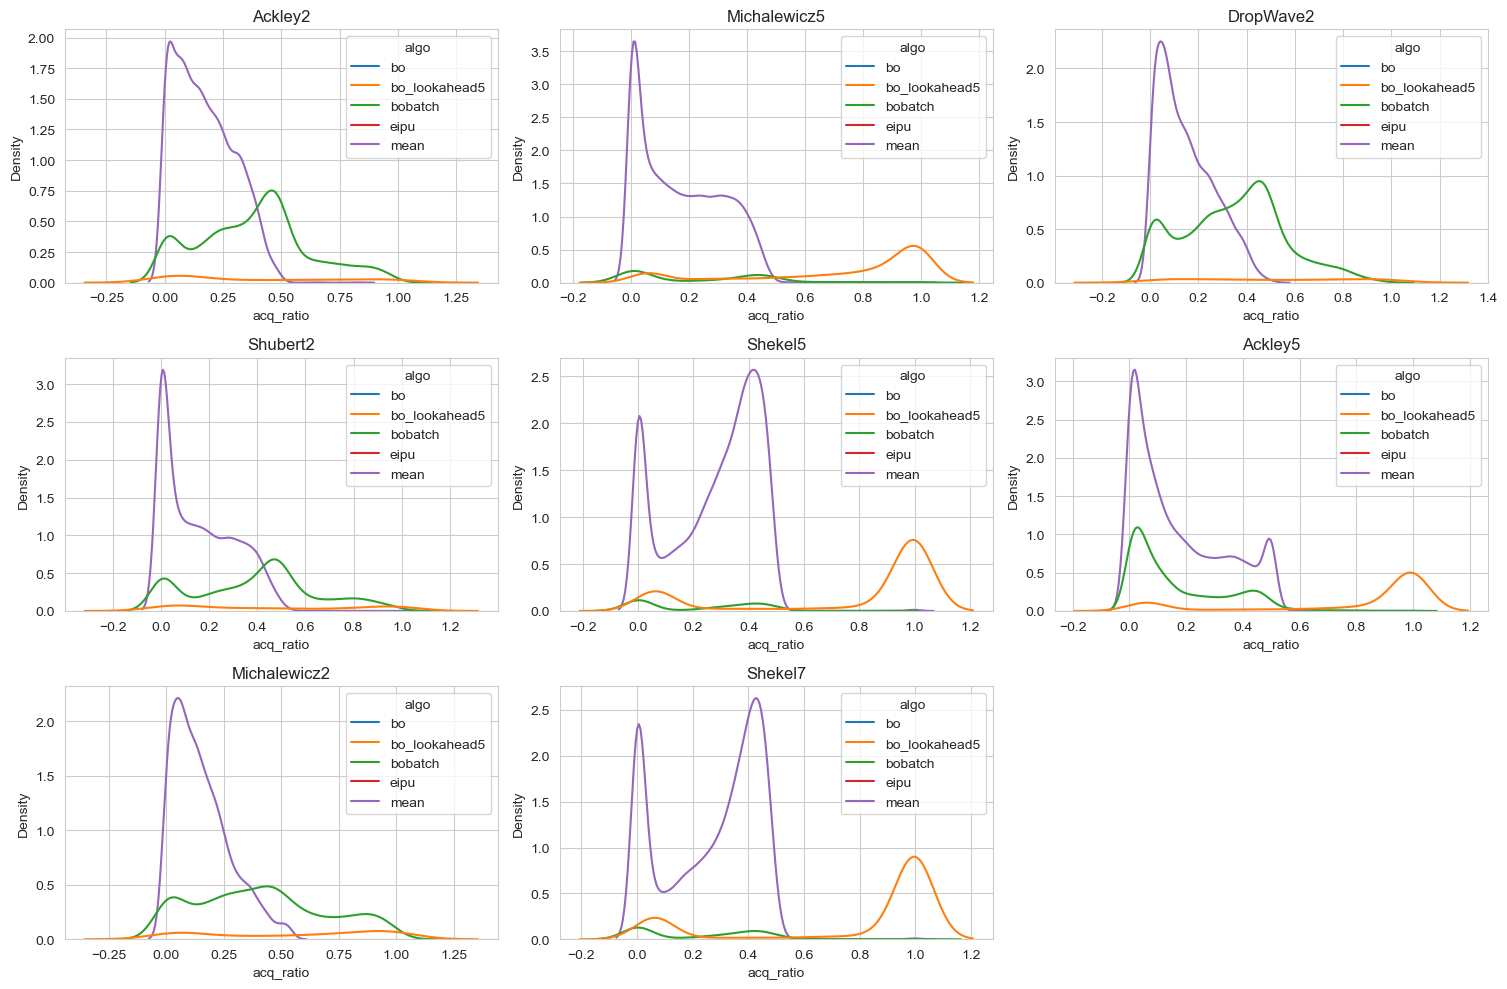

In [15]:
# Get unique functions
unique_functions = result['function'].unique()

# Calculate number of rows and columns for subplots
n = len(unique_functions)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

# Create figure with subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten axs to make it easier to iterate over
axs = axs.flatten()

# Loop over each unique function and each subplot
for func, ax in zip(unique_functions, axs):
    # Filter dataframe for current function
    df_func = result[result['function'] == func]

    # Plot KDE for point improvement deviation and setup improvement
    sns.kdeplot(data=df_func[(df_func['acq_ratio'] > 0) & (df_func['acq_ratio'] < 1)], x='acq_ratio', hue='algo',
                hue_order=['bo', 'bo_lookahead5', 'bobatch', 'eipu', 'mean'],
                ax=ax)
    ax.set_title(func)

# Remove unused subplots
for ax in axs[n:]:
    ax.remove()

plt.tight_layout()
plt.show()

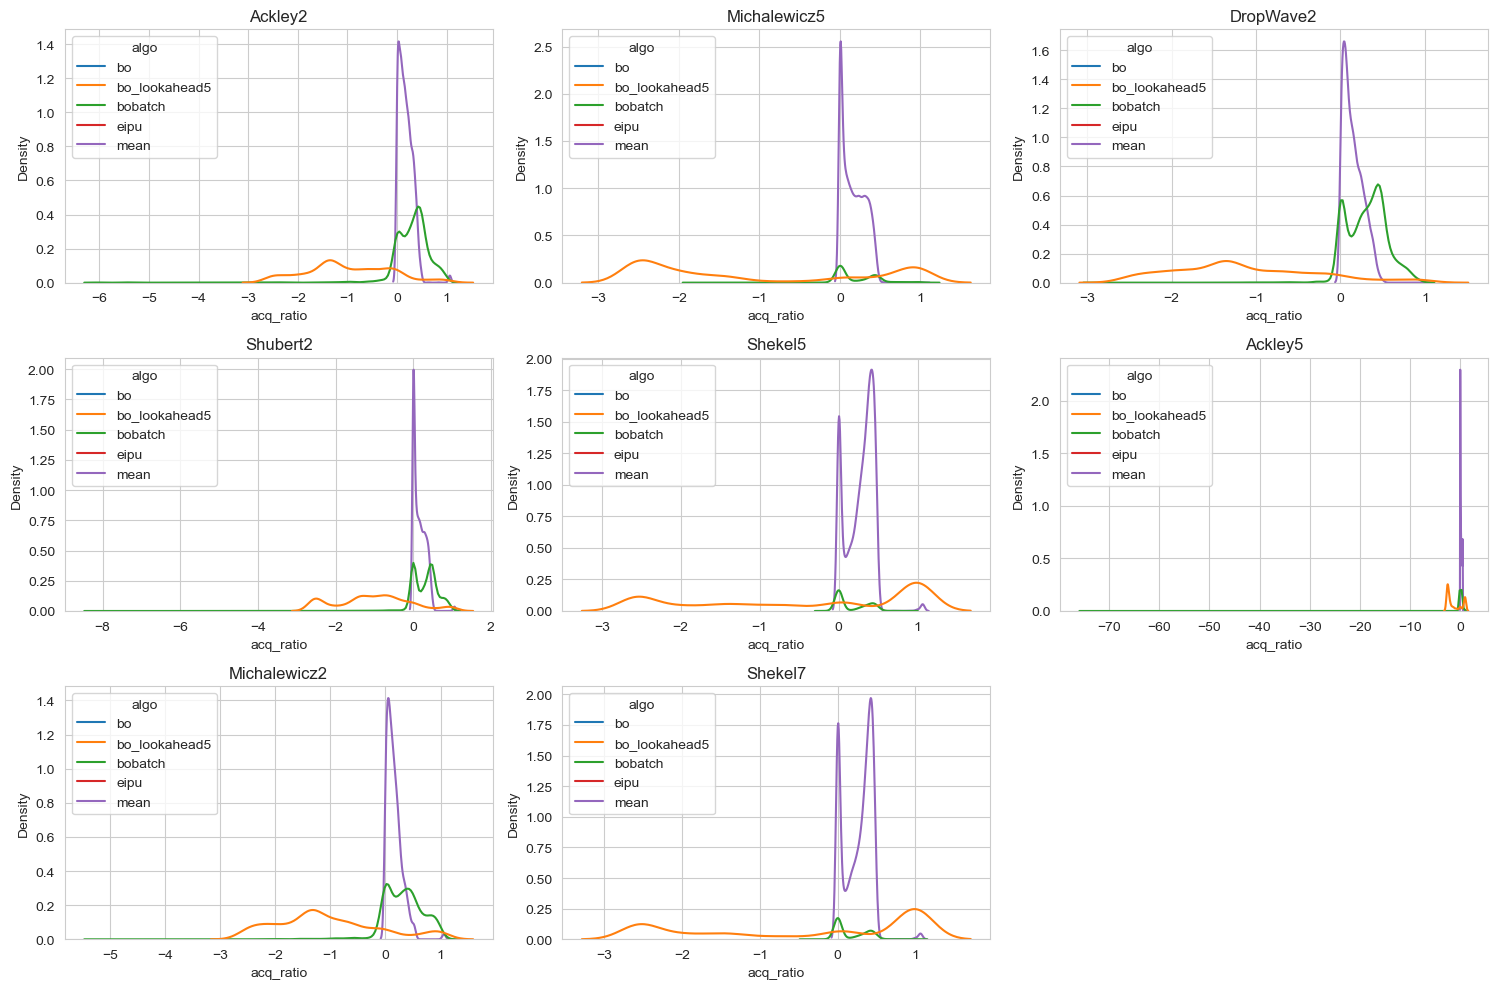

In [16]:
# Get unique functions
unique_functions = result['function'].unique()

# Calculate number of rows and columns for subplots
n = len(unique_functions)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

# Create figure with subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# Flatten axs to make it easier to iterate over
axs = axs.flatten()

# Loop over each unique function and each subplot
for func, ax in zip(unique_functions, axs):
    # Filter dataframe for current function
    df_func = result[result['function'] == func]

    # Plot KDE for point improvement deviation and setup improvement
    sns.kdeplot(data=df_func, x='acq_ratio', hue='algo',
                hue_order=['bo', 'bo_lookahead5', 'bobatch', 'eipu', 'mean'],
                ax=ax)
    ax.set_title(func)

# Remove unused subplots
for ax in axs[n:]:
    ax.remove()

plt.tight_layout()
plt.show()